In [ ]:
import pandas as pd
import numpy as np

In [ ]:
file = r'/content/train.csv' # for some reason the dropbox link is not working with wget
p3_df = pd.read_csv(file)    # so need to download the file locally and upload it in colab.

In [ ]:
p3_df.shape

(1306122, 3)

In [ ]:
p3_df.question_text[0]

'How did Quebec nationalists see their province as a nation in the 1960s?'

In [ ]:
p3_df.question_text[1]

'Do you have an adopted dog, how would you encourage people to adopt and not shop?'

In [ ]:
p3_df.question_text[8]

'Is there such a thing as dressing moderately, and if so, how is that different than dressing modestly?'

In [ ]:
p3_df.question_text[99999]

'Can you tell me some serums for oily skin available in India?'

In [ ]:
!wget -q --show-progress http://nlp.stanford.edu/data/glove.42B.300d.zip

glove.42B.300d.zip  100%[===================>]   1.75G  4.97MB/s    in 5m 53s  


In [ ]:
!unzip /content/glove.42B.300d.zip

Archive:  /content/glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [ ]:
!rm /content/glove.42B.300d.zip

In [ ]:
embeding_index={}

f=open('glove.42B.300d.txt',encoding='utf-8')

for line in f:
    values=line.split()
    word=values[0]
    coefs=np.asarray(values[1:],dtype='float32')
    embeding_index[word]=coefs
f.close()

In [ ]:
from sklearn.model_selection import train_test_split
data_train,data_test=train_test_split(p3_df,test_size=0.2)

In [ ]:
x_train=data_train['question_text']
y_train=data_train['target']
x_test=data_test['question_text']
y_test=data_test['target']

## Process sentence

In [ ]:
import re
import string

In [ ]:
def to_lower(word):
  result = word.lower()
  return result

In [ ]:
def remove_punctuation(word):
  result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
  return result

In [ ]:
def remove_whitespace(word):
  return word.strip()

In [ ]:
def replace_newline(word):
  return word.replace('\n','')

In [ ]:
def remove_number(word):
  return re.sub(r'\d+','',word)

In [ ]:
def clean_up_pipeline(sentence):
    cleaning_utils = [replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for x in cleaning_utils:
        sentence = x(sentence)
    return sentence

In [ ]:
x_train = [clean_up_pipeline(x) for x in x_train]
x_test = [clean_up_pipeline(x) for x in x_test]

## Process word by word

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [ ]:
x_train = [word_tokenize(x) for x in x_train]
x_test = [word_tokenize(x) for x in x_test]

In [ ]:
def remove_stop_words(words):
  return [i for i in words if i not in ENGLISH_STOP_WORDS]

In [ ]:
def word_stemmer(words):
  return [stemmer.stem(x) for x in words]

In [ ]:
def word_lemmatizer(words):
  return [lemmatizer.lemmatize(x) for x in words]

In [ ]:
def clean_token_pipeline(words):
  cleaning_utils = [remove_stop_words,
                    word_stemmer,
                    word_lemmatizer]

  for x in cleaning_utils:
    words = x(words)
  return words

In [ ]:
x_train = [clean_token_pipeline(x) for x in x_train]
x_test = [clean_token_pipeline(x) for x in x_test]

### Checking what the x_train now look like.

In [ ]:
x_train

[['come', 'peopl', 'hate'],
 ['sweep', 'wing', 'fix', 'space', 'shuttl', 'issu', 'lift', 'manag', 'land'],
 ['famou', 'alumnus', 'institut', 'charter', 'account', 'india', 'icai'],
 ['effect', 'sp', 'artilleri', 'ww'],
 ['good', 'hostel', 'backpack', 'india'],
 ['molli', 'help', 'forget', 'problem'],
 ['vegan', 'almond', 'cake', 'recip'],
 ['industri', 'syndicalist', 'countri', 'look', 'like'],
 ['gener', 'electr', 'solar', 'project'],
 ['mark', 'ftre', 'rank'],
 ['did',
  'axi',
  'alli',
  'offic',
  'use',
  'chanc',
  'make',
  'wealth',
  'corrupt',
  'ww'],
 ['im', 'new', 'quora', 'popular', 'quoran'],
 ['entranc',
  'exam',
  'sampl',
  'paper',
  'question',
  'bank',
  'm',
  'sc',
  'zoolog',
  'honor',
  'pune',
  'univers'],
 ['panchajani'],
 ['doe', 'balaji', 'vishwanathan', 'think', 'erdogan'],
 ['anti', 'romeo', 'squad'],
 ['treatment', 'leukemoid', 'reaction'],
 ['best', 'cruis', 'journey', 'india'],
 ['dick', 'hard', 'rock'],
 ['bank', 'drop', 'overdraft', 'charg'],
 [

## Pretrained Embedding

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
## some config values
embed_size = 300 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 31 # max number of words in a question to use

In [ ]:
# np.percentile(sent_lens,95)

31.0

In [ ]:
# max_len=31

tk=Tokenizer(num_words=max_feature)

tk.fit_on_texts(x_train)

seq_train=tk.texts_to_sequences(x_train)
seq_test=tk.texts_to_sequences(x_test)

vocab_size=len(tk.word_index)

seq_train_matrix= pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix= pad_sequences(seq_test,maxlen=max_len)

In [ ]:
seq_train_matrix.shape, seq_test_matrix.shape

((1044897, 31), (261225, 31))

In [ ]:
embedding_matrix=np.zeros((vocab_size+1,300))

for word,i in tk.word_index.items():
    embed_vector=embeding_index.get(word)
    if embed_vector is not None:
        embedding_matrix[i]=embed_vector

In [ ]:
len(embedding_matrix)

158592

In [ ]:
inputs=Input(name='text_input',shape=[max_len,])

embed=Embedding(vocab_size+1,
                300,
                input_length=max_len,
                mask_zero=True,
                weights=[embedding_matrix],
                trainable=False)(inputs)

x = Bidirectional(GRU(64, return_sequences=True))(embed)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
final_layer = Dense(1, activation="sigmoid")(x)

model=Model(inputs=inputs,outputs=final_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_input (InputLayer)     [(None, 31)]              0         
                                                                 
 embedding (Embedding)       (None, 31, 300)           47582700  
                                                                 
 bidirectional (Bidirection  (None, 31, 128)           140544    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 16)                2064      
                                                                 
 dropout (Dropout)           (None, 16)                0     

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
project_2 = model.fit(seq_train_matrix,
                      y_train.values,
                      validation_data=(seq_test_matrix,y_test.values),
                      epochs=10,
                      # class_weight={0:1,1:10},
                      use_multiprocessing=True,
                      batch_size=512)

Epoch 1/10
2041/2041 [==============================] - 1071s 517ms/step - loss: 0.1348 - acc: 0.9486 - val_loss: 0.1206 - val_acc: 0.9533
Epoch 2/10
2041/2041 [==============================] - 1235s 605ms/step - loss: 0.1171 - acc: 0.9532 - val_loss: 0.1166 - val_acc: 0.9545
Epoch 3/10
2041/2041 [==============================] - 1077s 528ms/step - loss: 0.1110 - acc: 0.9560 - val_loss: 0.1158 - val_acc: 0.9543
Epoch 4/10
2041/2041 [==============================] - 1074s 526ms/step - loss: 0.1060 - acc: 0.9580 - val_loss: 0.1157 - val_acc: 0.9547
Epoch 5/10
2041/2041 [==============================] - 1117s 547ms/step - loss: 0.1015 - acc: 0.9594 - val_loss: 0.1167 - val_acc: 0.9538
Epoch 6/10
2041/2041 [==============================] - 952s 466ms/step - loss: 0.0971 - acc: 0.9609 - val_loss: 0.1190 - val_acc: 0.9540
Epoch 7/10
2041/2041 [==============================] - 1081s 530ms/step - loss: 0.0928 - acc: 0.9623 - val_loss: 0.1203 - val_acc: 0.9540
Epoch 8/10
2041/2041 [======

In [ ]:
p=model.predict(seq_test_matrix)

8164/8164 [==============================] - 330s 40ms/step


In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,p)

0.9409708591226933

## Plotting the result

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

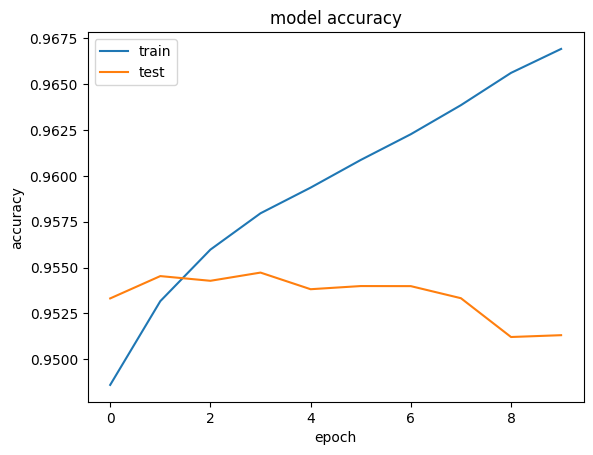

In [ ]:
plt.plot(project_2.history['acc'])
plt.plot(project_2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix,  precision_score, recall_score

In [ ]:
y_predict  = [1 if x>0.5 else 0 for x in p]

In [ ]:
confusion_matrix(y_test,y_predict)

array([[239238,   5928],
       [  6791,   9268]])

In [ ]:
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_predict)))

Precision: 60.99%
Recall: 57.71%
